In [17]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from _data.data_utils import read_in
from _fitting.fitting_utils import hist_plot, CI_plot, CI_plot_alt, CI_plot_both
import pymc as pm
import arviz as az
from patsy import dmatrix
import nutpie
import time
from pprint import pprint
from IPython.display import display

az.style.use("arviz-darkgrid")

laptop_or_server = 0
if laptop_or_server:
    # laptop folder
    folder = "../../_data/p-dengue/"
else:
    # server folder
    folder = "../../../../../data/lucaratzinger_data/p_dengue/"

In [18]:
data = read_in(folder, admin=2, max_lag=0)
data = data.dropna()
data = data.loc[data['year']<2020, :]

rng = np.random.default_rng(42)
keep_admin2 = rng.choice(
    data["admin2"].unique(),
    size=int(0.5 * data["admin2"].nunique()),
    replace=False
)
#data = data[data["admin2"].isin(keep_admin2)]

In [19]:
data

admin1         admin2  year  month  cases   ONI  \
0       ACEH       SIMEULUE  2016      1    1.0  2.48   
1       ACEH       SIMEULUE  2016      2    8.0  2.14   
2       ACEH       SIMEULUE  2016      3    9.0  1.58   
3       ACEH       SIMEULUE  2016      4   14.0  0.94   
4       ACEH       SIMEULUE  2016      5    4.0  0.39   
...      ...            ...   ...    ...    ...   ...   
55447  PAPUA  KOTA JAYAPURA  2019      8    5.0  0.14   
55448  PAPUA  KOTA JAYAPURA  2019      9    1.0  0.19   
55449  PAPUA  KOTA JAYAPURA  2019     10    1.0  0.35   
55450  PAPUA  KOTA JAYAPURA  2019     11    1.0  0.51   
55451  PAPUA  KOTA JAYAPURA  2019     12    7.0  0.55   

       t2m_mean_unweighted (0)  t2m_mean_pop_weighted (0)  \
0                    300.32922                 300.347840   
1                    300.51236                 300.532226   
2                    300.52810                 300.551347   
3                    300.54373                 300.565193   
4                    300.65067                 300.670510   
...                        ...                        ...   
55447                298.17090                 298.246027   
55448                298.61910                 298.666391   
55449                298.49250                 298.539236   
55450                298.82916                 298.881520   
55451                298.87875                 298.932890   

       t2m_min_unweighted (0)  t2m_min_pop_weighted (0)  ...  \
0                   297.62756                297.676417  ...   
1                   297.90063                297.925451  ...   
2                   298.03680                298.078477  ...   
3                   298.26874                298.297523  ...   
4                   298.33392                298.373199  ...   
...                       ...                       ...  ...   
55447               295.41640                295.472186  ...   
55448               295.49188                295.627868  ...   
55449               295.24090                295.316480  ...   
55450               295.82224                295.915472  ...   
55451               295.86930                295.931388  ...   

       urbanisation_nonweighted  urbanisation_pop_weighted  \
0                      0.010998                   0.078463   
1                      0.010998                   0.078463   
2                      0.010998                   0.078463   
3                      0.010998                   0.078463   
4                      0.010998                   0.078463   
...                         ...                        ...   
55447                  0.100398                   0.925304   
55448                  0.100398                   0.925304   
55449                  0.100398                   0.925304   
55450                  0.100398                   0.925304   
55451                  0.100398                   0.925304   

       surveillance_nonweighted  surveillance_pop_weighted  \
0                      0.306564                   0.389898   
1                      0.306564                   0.389898   
2                      0.306564                   0.389898   
3                      0.306564                   0.389898   
4                      0.306564                   0.389898   
...                         ...                        ...   
55447                  0.552229                   0.859279   
55448                  0.552229                   0.859279   
55449                  0.552229                   0.859279   
55450                  0.552229                   0.859279   
55451                  0.552229                   0.859279   

       urban_surveillance_nonweighted  urban_surveillance_pop_weighted  \
0                            0.774953                         0.768781   
1                            0.774953                         0.768781   
2                            0.774953                         0.768781   
3                            0.77

In [20]:
list(data.columns)

['admin1',
 'admin2',
 'year',
 'month',
 'cases',
 'ONI',
 't2m_mean_unweighted (0)',
 't2m_mean_pop_weighted (0)',
 't2m_min_unweighted (0)',
 't2m_min_pop_weighted (0)',
 't2m_max_unweighted (0)',
 't2m_max_pop_weighted (0)',
 'rh_mean_unweighted (0)',
 'rh_mean_pop_weighted (0)',
 'tp_24hmean_unweighted (0)',
 'tp_24hmean_pop_weighted (0)',
 'tp_24hmax_unweighted (0)',
 'tp_24hmax_pop_weighted (0)',
 'population',
 'urbanisation_nonweighted',
 'urbanisation_pop_weighted',
 'surveillance_nonweighted',
 'surveillance_pop_weighted',
 'urban_surveillance_nonweighted',
 'urban_surveillance_pop_weighted',
 'density_unweighted',
 'density_pop_weighted',
 'urban_density_unweighted',
 'urban_density_pop_weighted']

---
# Poisson Intercept Only

In [21]:
model_intercept_p = pm.Model()
with model_intercept_p:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Link
    log_mu = (intercept +
              pm.math.log(data['population']))

    # Likelihood
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_mu), observed=data['cases'])

In [22]:
with model_intercept_p:
    s = time.time()
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    s1 = time.time()
    pm.compute_log_likelihood(idata, progressbar=False)
    s2 = time.time()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42, progressbar=False)
    print(f'Posterior Sampling {s1 - s:.2f} seconds')
    print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')
    print(f'Posterior Predictive Sampling {time.time()-s2:.2f} seconds')

Sampling: [y_obs]


Posterior Sampling 2.45 seconds
Log Likelihood Compute 1.54 seconds
Posterior Predictive Sampling 10.12 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -10.254  0.001 -10.257  -10.251        0.0      0.0    3291.0   

           ess_tail  r_hat  
intercept    5801.0    1.0

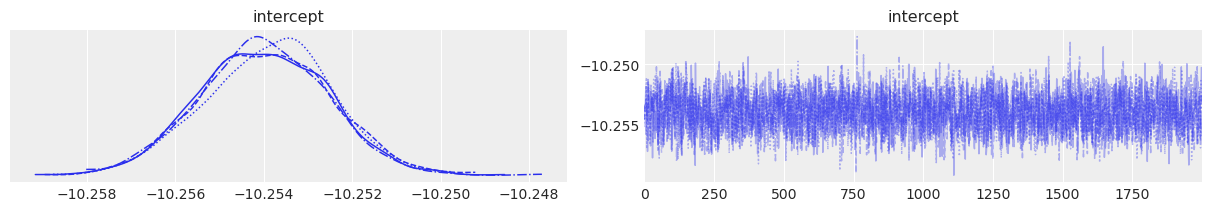

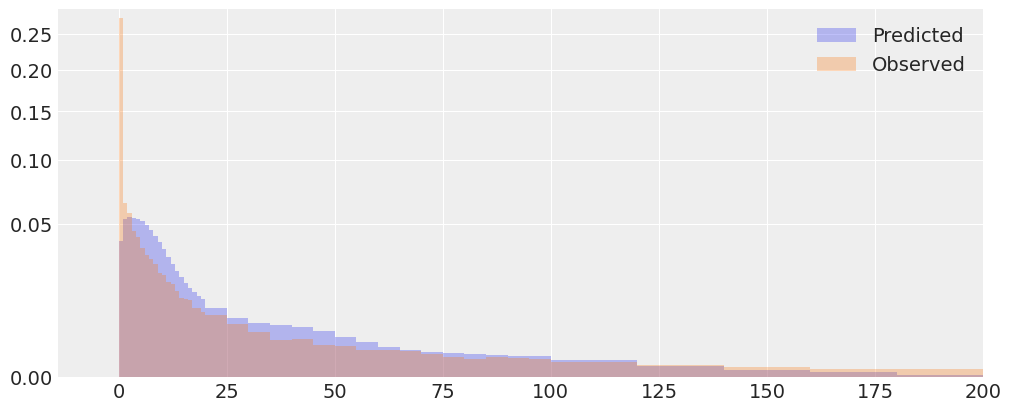

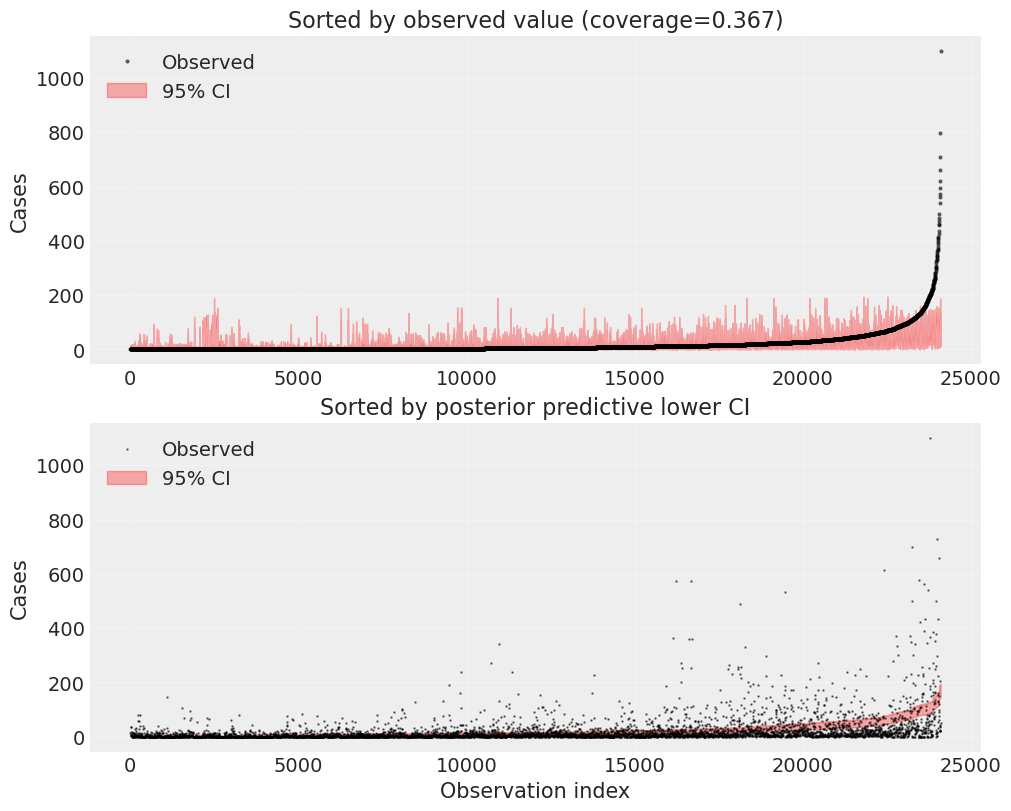

In [9]:
var_names = ['intercept']
display(az.summary(idata, var_names=var_names))
az.plot_trace(idata, var_names=var_names)
hist_plot(idata, figsize=(10,4))
CI_plot_both(idata, figsize=(10,8))


In [10]:
# Can see that the observed distributions has more mass on zero and extreme values

Computed from 8000 posterior samples and 24107 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -469902.13  9995.73
p_loo      104.16        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     24107  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

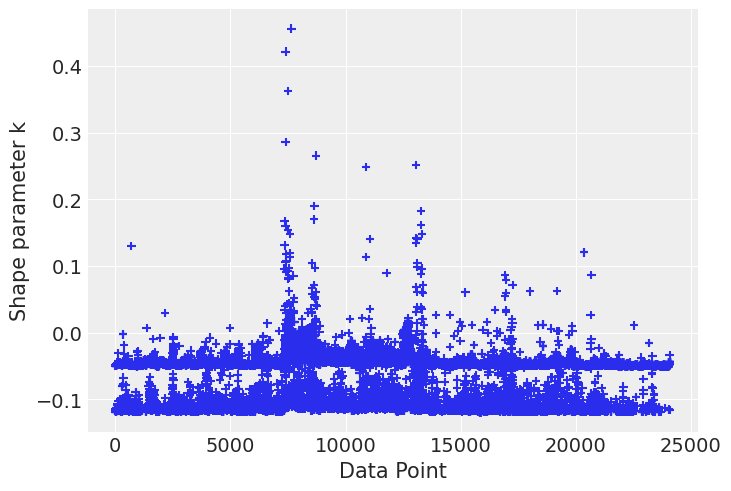

In [11]:
loo = az.loo(idata)
az.plot_khat(loo)
loo

---
# NB Intercept Only

In [12]:
model_intercept_nb = pm.Model()
with model_intercept_nb:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Link
    log_mu = (intercept +
              pm.math.log(data['population']))

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [13]:
with model_intercept_nb:
    s = time.time()
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    s1 = time.time()
    pm.compute_log_likelihood(idata, progressbar=False)
    s2 = time.time()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42, progressbar=False)
    print(f'Posterior Sampling {s1 - s:.2f} seconds')
    print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')
    print(f'Posterior Predictive Sampling {time.time()-s2:.2f} seconds')

Sampling: [y_obs]


Posterior Sampling 36.89 seconds
Log Likelihood Compute 10.49 seconds
Posterior Predictive Sampling 21.13 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -9.955  0.011  -9.976   -9.935        0.0      0.0    8973.0   
alpha      0.385  0.004   0.378    0.392        0.0      0.0    8692.0   

           ess_tail  r_hat  
intercept    6217.0    1.0  
alpha        6073.0    1.0

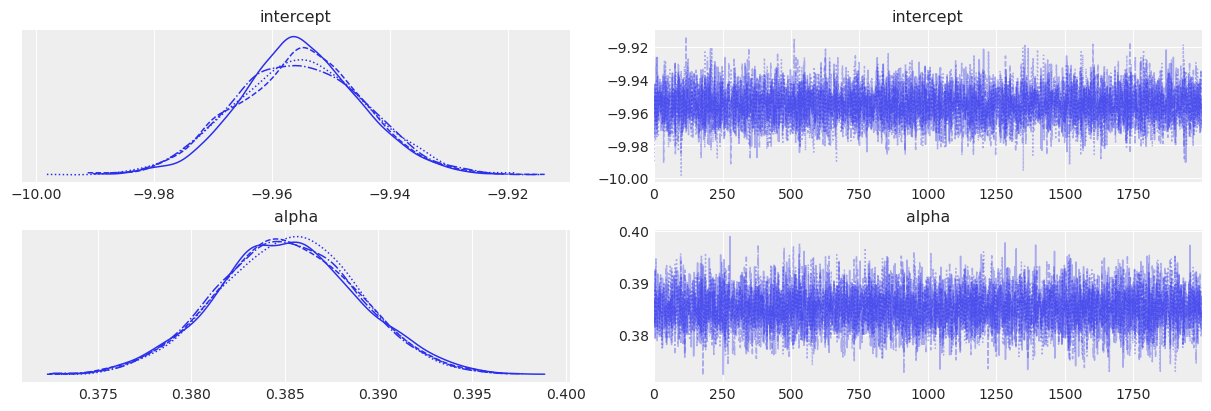

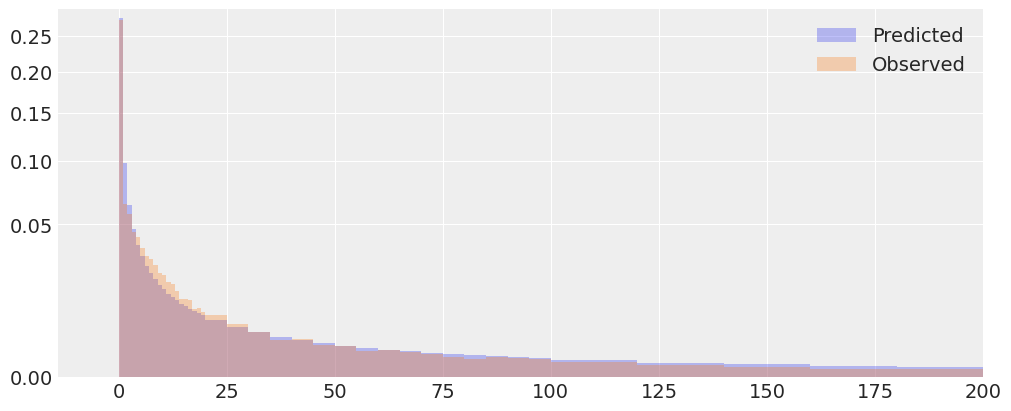

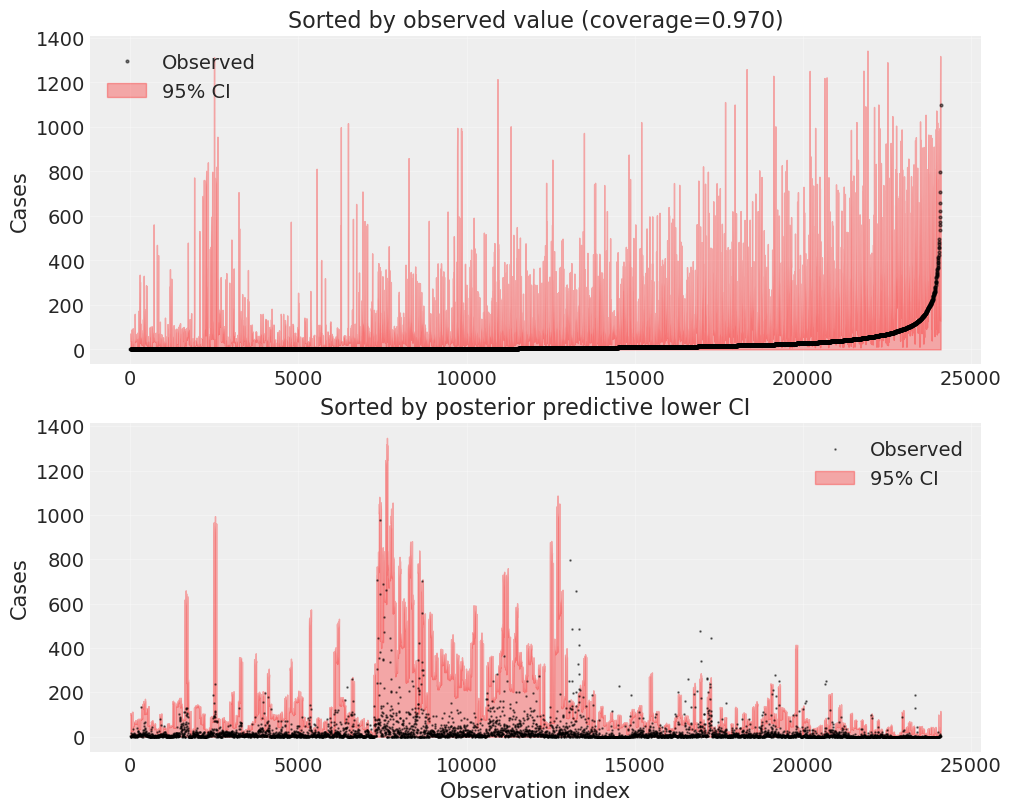

In [14]:
var_names = ['intercept', 'alpha']
display(az.summary(idata, var_names=var_names))
az.plot_trace(idata, var_names=var_names)
hist_plot(idata, figsize=(10,4))
CI_plot_both(idata, figsize=(10,8))

In [15]:
# Predicted puts slightly more mass on extreme, observed more mass on the low moderate values

Computed from 8000 posterior samples and 24107 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -83186.13   311.80
p_loo        3.78        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     24107  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

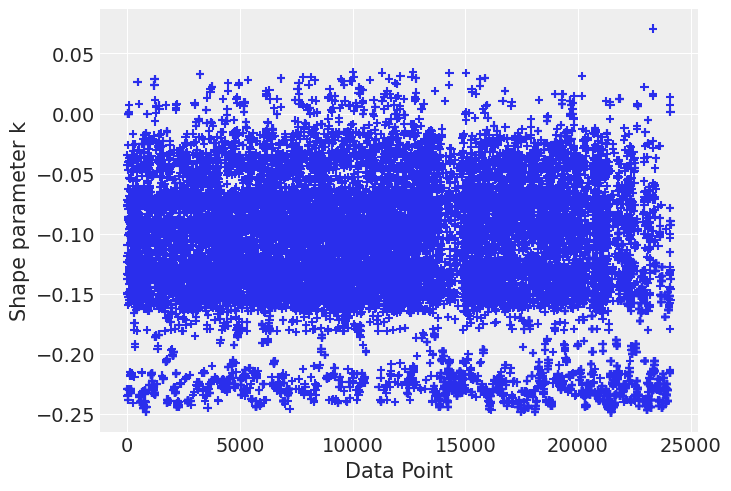

In [16]:
loo = az.loo(idata)
az.plot_khat(loo)
loo

---
# NB Incidence + Surveillance

In [20]:
model_intercept_nb_s = pm.Model()
with model_intercept_nb_s:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Link
    log_mu = (intercept +
              pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3))

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [15]:
with model_intercept_nb_s:
    s = time.time()
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    s1 = time.time()
    pm.compute_log_likelihood(idata, progressbar=False)
    s2 = time.time()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42, progressbar=False)
    print(f'Posterior Sampling {s1 - s:.2f} seconds')
    print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')
    print(f'Posterior Predictive Sampling {time.time()-s2:.2f} seconds')

Sampling: [y_obs]


Posterior Sampling 8.13 seconds
Log Likelihood Compute 3.45 seconds
Posterior Predictive Sampling 14.25 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -9.648  0.011  -9.670   -9.628        0.0      0.0    8103.0   
alpha      0.373  0.004   0.366    0.380        0.0      0.0    8213.0   

           ess_tail  r_hat  
intercept    5697.0    1.0  
alpha        5913.0    1.0

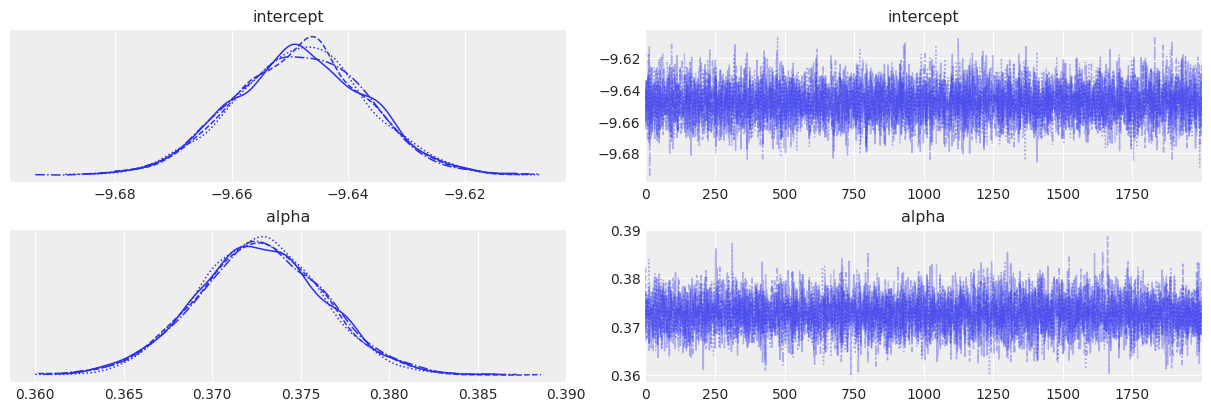

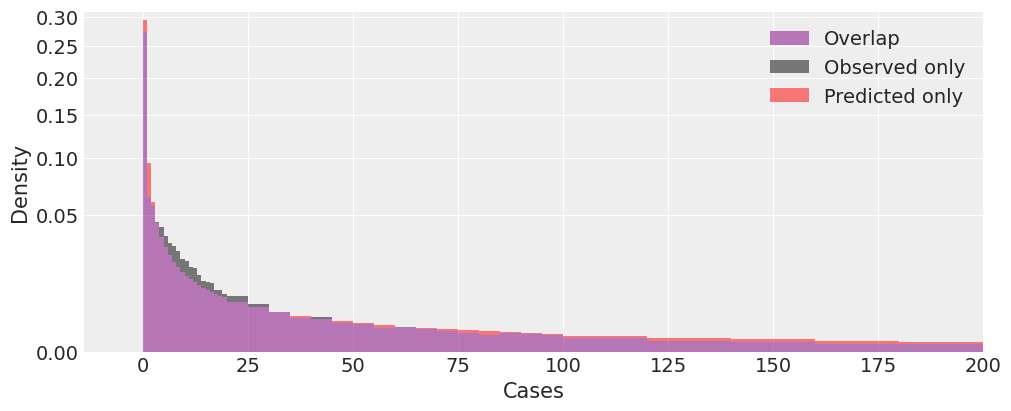

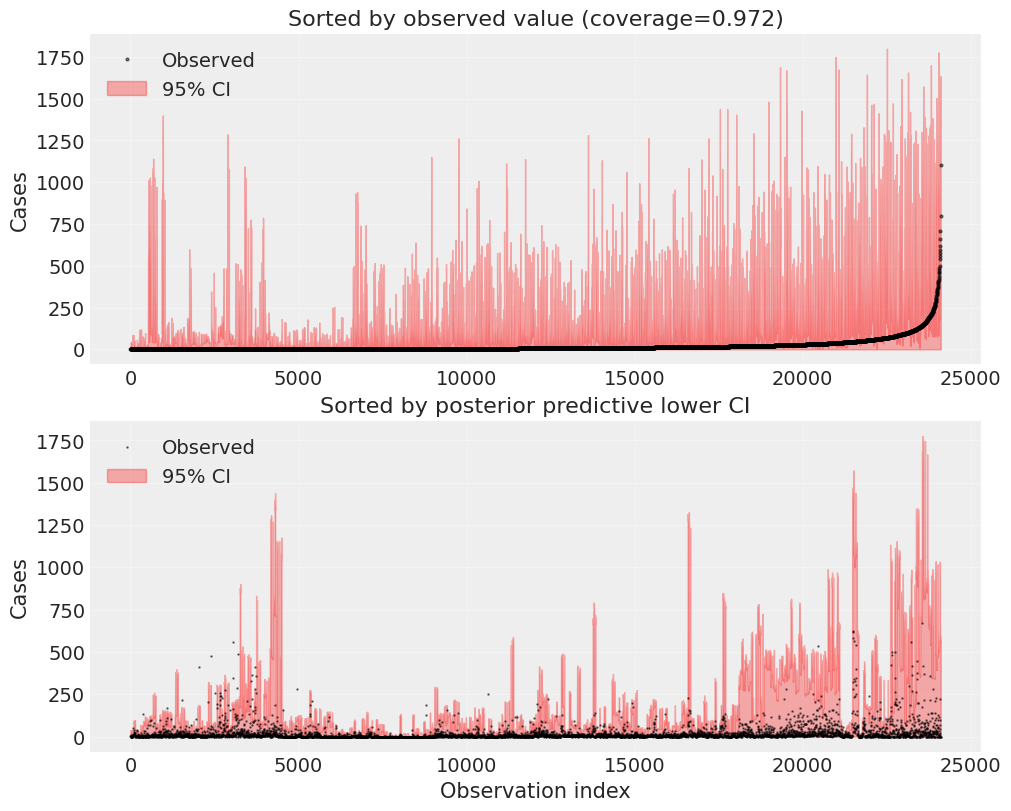

In [16]:
var_names = ['intercept', 'alpha']
display(az.summary(idata, var_names=var_names))
az.plot_trace(idata, var_names=var_names)
hist_plot(idata, figsize=(10,4))
CI_plot_both(idata, figsize=(10,8))

Computed from 8000 posterior samples and 24107 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -83765.24   351.60
p_loo        6.02        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     24107  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

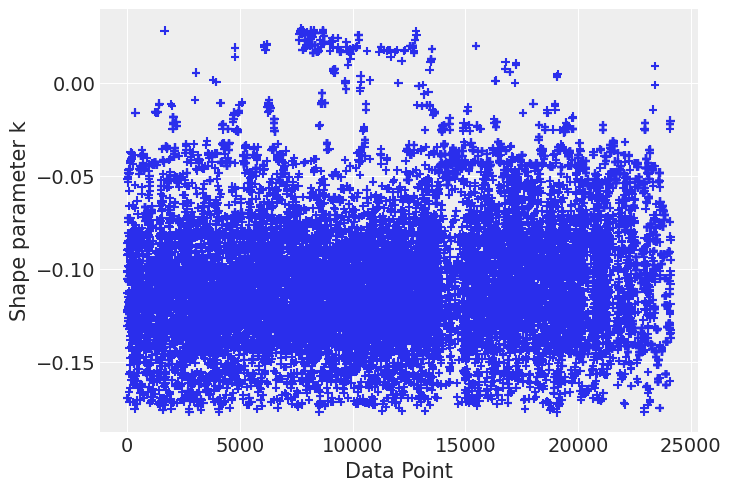

In [17]:
loo = az.loo(idata)
az.plot_khat(loo)
loo

---
# Negative Binomial Intercept + Surveillance + Urbanisation

In [19]:
model_intercept_nb_su = pm.Model()
with model_intercept_nb_su:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # Link
    log_mu = (intercept + pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3) +
              beta_u*data['urbanisation_pop_weighted'])

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [21]:
with model_intercept_nb_su:
    s = time.time()
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    s1 = time.time()
    pm.compute_log_likelihood(idata, progressbar=False)
    s2 = time.time()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42, progressbar=False)
    print(f'Posterior Sampling {s1 - s:.2f} seconds')
    print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')
    print(f'Posterior Predictive Sampling {time.time()-s2:.2f} seconds')

Sampling: [y_obs]


Posterior Sampling 18.54 seconds
Log Likelihood Compute 4.38 seconds
Posterior Predictive Sampling 15.61 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -9.440  0.023  -9.482   -9.396      0.000      0.0    2697.0   
alpha      0.373  0.004   0.366    0.379      0.000      0.0    6023.0   
beta_u    -0.400  0.036  -0.467   -0.331      0.001      0.0    2677.0   

           ess_tail  r_hat  
intercept    3107.0    1.0  
alpha        5052.0    1.0  
beta_u       3269.0    1.0

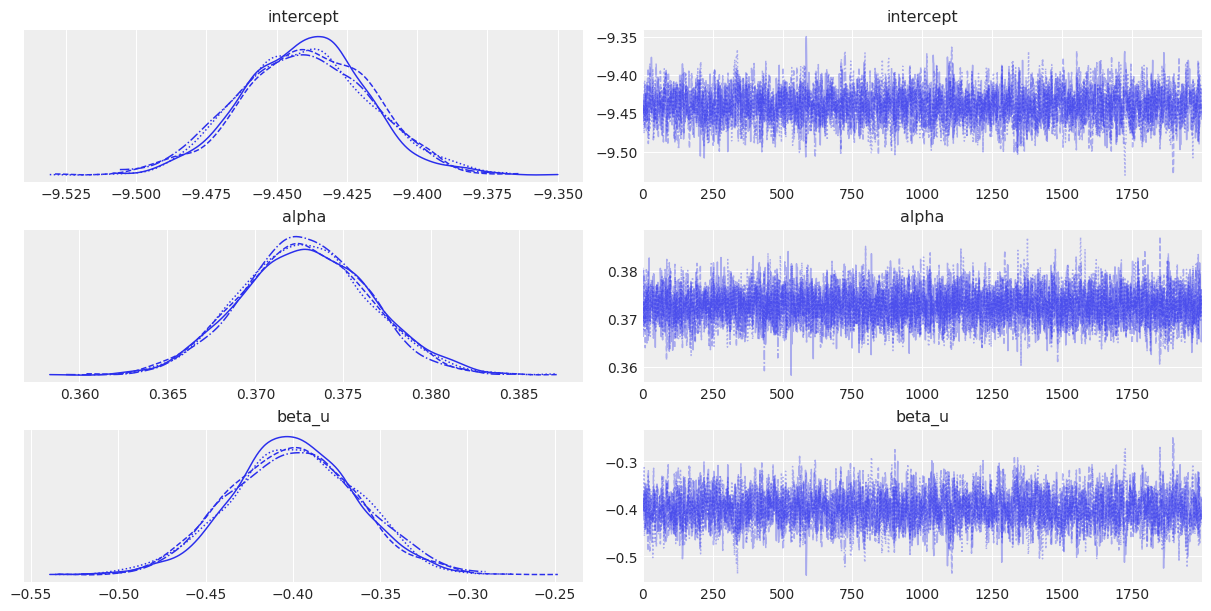

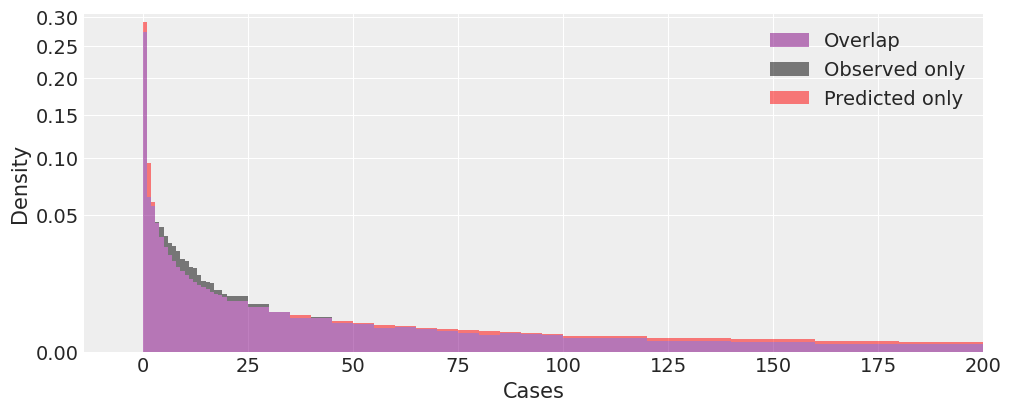

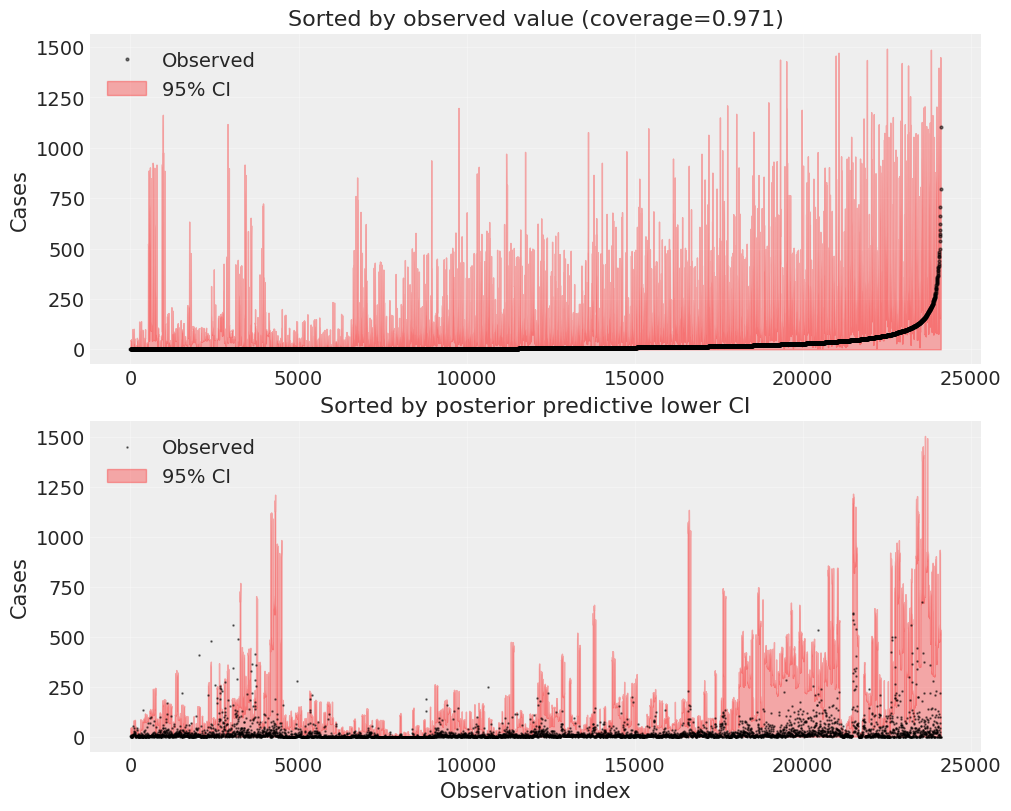

In [22]:
var_names = ['intercept', 'alpha', 'beta_u']
display(az.summary(idata, var_names=var_names))
az.plot_trace(idata, var_names=var_names)
hist_plot(idata, figsize=(10,4))
CI_plot_both(idata, figsize=(10,8))

Computed from 8000 posterior samples and 24107 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -83705.34   343.29
p_loo        8.89        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     24107  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

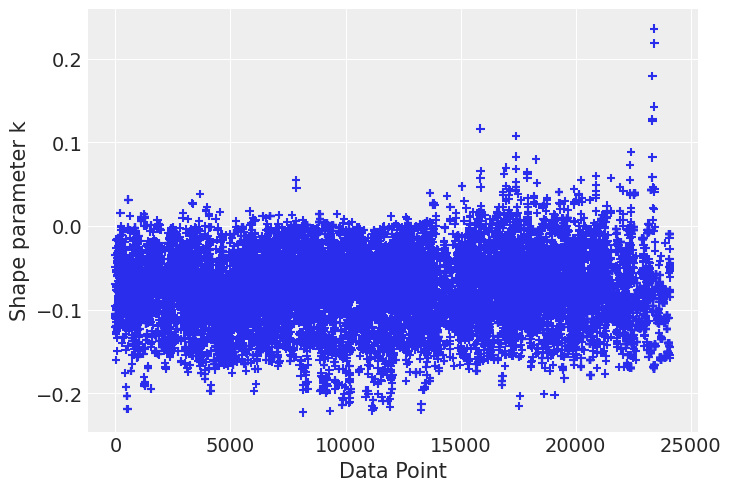

In [23]:
loo = az.loo(idata)
az.plot_khat(loo)
loo

---
# Negative Binomial Intercept + Surveillance + Urbanisation + Spline (1)

In [ ]:
model_intercept_nb_sus1 = pm.Model()
with model_intercept_nb_sus1:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # spline
    # degree=3 gives cubic splines
    num_knots1 = 3
    d = data['t2m_mean_pop_weighted (0)']
    knot_list1 = np.percentile(d, np.linspace(0, 100, num_knots1 + 2))[1:-1]
    B1 = dmatrix(
    "bs(s1, knots=knots, degree=3, include_intercept=False)-1",
    {"s1": d, "knots": knot_list1},)
    
    # Spline coefficients
    sigma_w1 = pm.HalfNormal("sigma_w1", sigma=0.5)
    w1 = pm.Normal("w1", mu=0, sigma=1, size=B1.shape[1], dims="splines")
    
    # Spline contribution
    f_s1 = sigma_w1 * pm.math.dot(np.asarray(B1, order="F"), w1)

    # Link
    log_mu = (intercept + pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3) +
              beta_u*data['urbanisation_pop_weighted'] +
              f_s1)

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [29]:
with model_intercept_nb_sus1:
    s = time.time()
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    s1 = time.time()
    pm.compute_log_likelihood(idata, progressbar=False)
    s2 = time.time()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42, progressbar=False)
    print(f'Posterior Sampling {s1 - s:.2f} seconds')
    print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')
    print(f'Posterior Predictive Sampling {time.time()-s2:.2f} seconds')

Sampling: [y_obs]


Posterior Sampling 547.81 seconds
Log Likelihood Compute 3.50 seconds
Posterior Predictive Sampling 14.83 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -14.560  0.756 -15.981  -13.187      0.022    0.021    1220.0   
alpha       0.380  0.004   0.373    0.387      0.000    0.000    8910.0   
beta_u     -0.417  0.036  -0.484   -0.351      0.000    0.000    6593.0   
w[0]        1.138  0.408   0.362    1.895      0.011    0.009    1517.0   
w[1]        2.536  0.294   2.009    3.099      0.008    0.005    1465.0   
w[2]        2.362  0.287   1.827    2.904      0.008    0.005    1445.0   
w[3]        2.530  0.296   1.982    3.085      0.008    0.005    1445.0   
w[4]        1.695  0.289   1.165    2.255      0.007    0.006    1570.0   
w[5]        1.208  0.324   0.623    1.854      0.007    0.005    1896.0   

           ess_tail  r_hat  
intercept    1084.0    1.0  
alpha        5454.0    1.0  
beta_u       4829.0    1.0  
w[0]         1422.0    1.0  
w[1]         1564.0    1.0  
w[2]         1491.0    1.0  
w[3]         1543.0    1.0  
w[4]         1651.0    1.0  
w[5]         1973.0    1.0

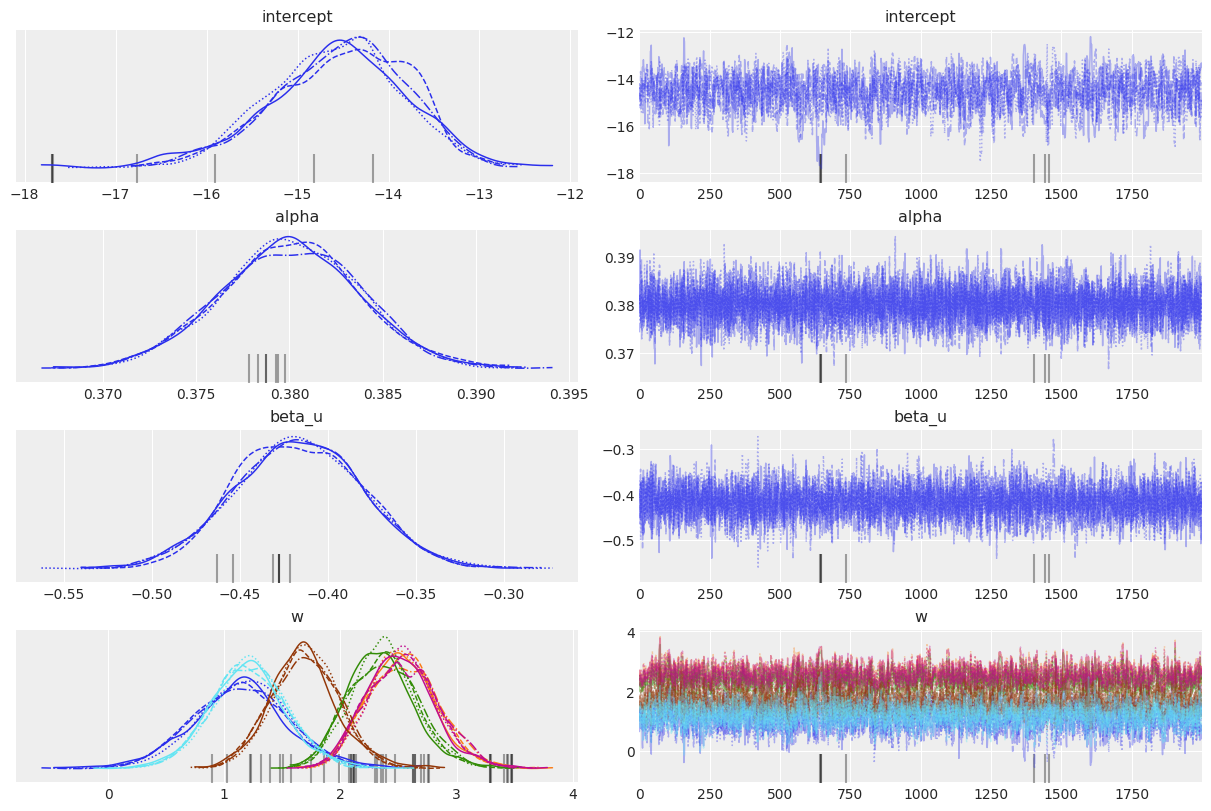

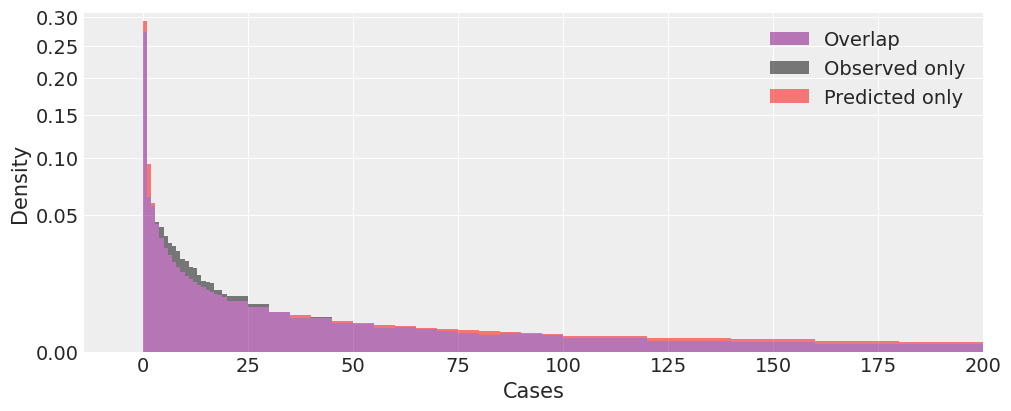

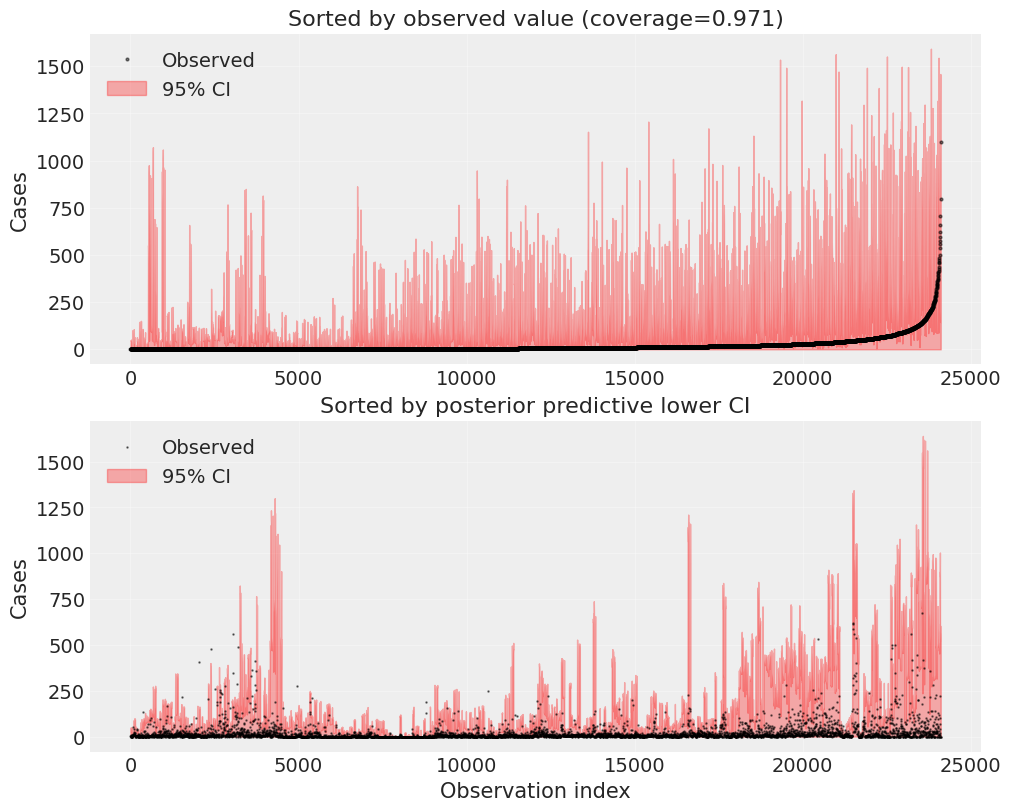

In [ ]:
var_names = ['intercept', 'alpha', 'beta_u', 'sigma_w1', 'w1']
display(az.summary(idata, var_names=var_names))
az.plot_trace(idata, var_names=var_names)
hist_plot(idata, figsize=(10,4))
CI_plot_both(idata, figsize=(10,8))

Computed from 8000 posterior samples and 24107 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -83416.94   341.68
p_loo       20.42        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     24107  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

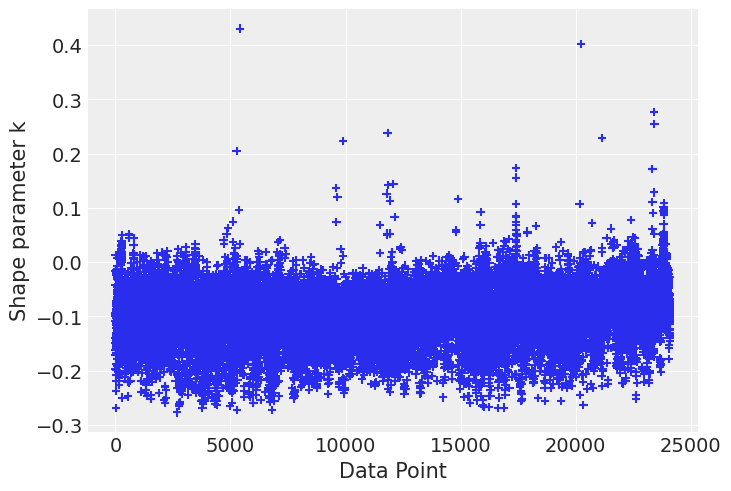

In [31]:
loo = az.loo(idata)
az.plot_khat(loo)
loo

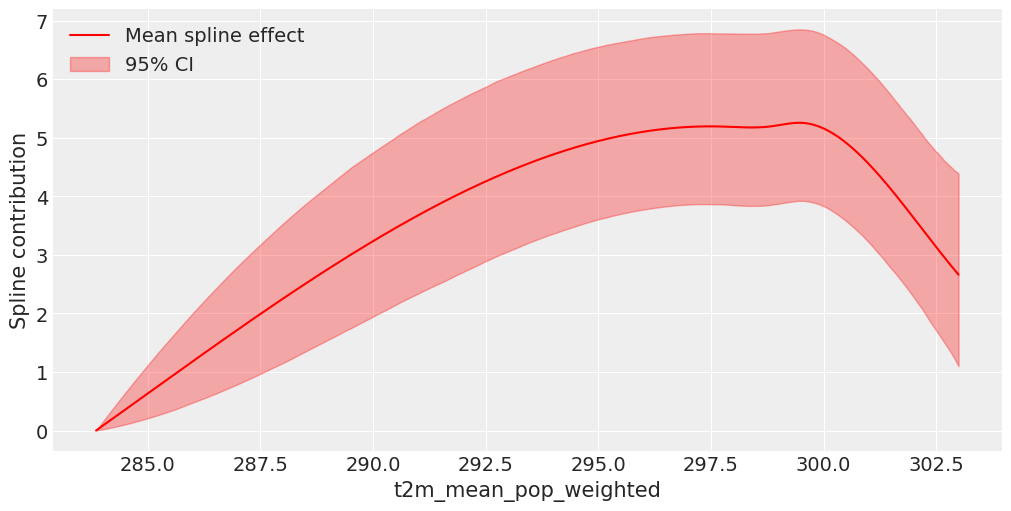

In [38]:
# Extract posterior samples
w_samples = idata.posterior['w'].stack(draws=("chain", "draw")).values  # (n_basis, n_draws)
sigma_w_samples = idata.posterior['sigma_w'].stack(draws=("chain", "draw")).values  # (n_draws,)

# Compute spline contributions for each draw
f_s1_samples = (np.asarray(B1, order="F") @ w_samples) * sigma_w_samples  # broadcasting: (n_obs, n_draws)

# Compute mean and 95% credible intervals
f_s1_mean = f_s1_samples.mean(axis=1)
f_s1_lower = np.percentile(f_s1_samples, 2.5, axis=1)
f_s1_upper = np.percentile(f_s1_samples, 97.5, axis=1)

# Plot
index = np.argsort(data['t2m_mean_pop_weighted (0)'])
plt.figure(figsize=(10,5))
plt.plot(np.array(data['t2m_mean_pop_weighted (0)'])[index], f_s1_mean[index], color='red', label='Mean spline effect')
plt.fill_between(np.array(data['t2m_mean_pop_weighted (0)'])[index], f_s1_lower[index], f_s1_upper[index], color='red', alpha=0.3, label='95% CI')
plt.xlabel('t2m_mean_pop_weighted')
plt.ylabel('Spline contribution')
plt.legend()
plt.show()


---

In [43]:
model_intercept_nb_sus2 = pm.Model()
with model_intercept_nb_sus2:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # spline 1
    # degree=3 gives cubic splines
    num_knots1 = 3
    d1 = data['t2m_mean_pop_weighted (0)']
    knot_list1 = np.percentile(d1, np.linspace(0, 100, num_knots1 + 2))[1:-1]
    B1 = dmatrix(
    "bs(s1, knots=knots, degree=3, include_intercept=False)-1",
    {"s1": d1, "knots": knot_list1},)
    
    # Spline coefficients
    sigma_w1 = pm.HalfNormal("sigma_w1", sigma=0.5)
    w1 = pm.Normal("w1", mu=0, sigma=1, size=B1.shape[1], dims="splines")
    
    # Spline contribution
    f_s1 = sigma_w1 * pm.math.dot(np.asarray(B1, order="F"), w1)

    # spline 2
    num_knots2 = 3
    d2 = np.log(data['tp_24hmean_pop_weighted (0)'])
    knot_list2 = np.percentile(d2, np.linspace(0, 100, num_knots2 + 2))[1:-1]
    B2 = dmatrix(
    "bs(s2, knots=knots, degree=3, include_intercept=False)-1",
    {"s2": d2, "knots": knot_list2},)
    
    # Spline coefficients
    sigma_w2 = pm.HalfNormal("sigma_w2", sigma=0.5)
    w2 = pm.Normal("w2", mu=0, sigma=1, size=B2.shape[1], dims="splines")
    
    # Spline contribution
    f_s2 = sigma_w2 * pm.math.dot(np.asarray(B2, order="F"), w2)

    # Link
    log_mu = (intercept + pm.math.log(data['population']) +
              pm.math.log(data['urban_surveillance_pop_weighted']+1e-3) +
              beta_u*data['urbanisation_pop_weighted'] +
              f_s1 +
              f_s2)

    # Likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [44]:
with model_intercept_nb_sus2:
    s = time.time()
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    s1 = time.time()
    pm.compute_log_likelihood(idata, progressbar=False)
    s2 = time.time()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42, progressbar=False)
    print(f'Posterior Sampling {s1 - s:.2f} seconds')
    print(f'Log Likelihood Compute {s2 - s1:.2f} seconds')
    print(f'Posterior Predictive Sampling {time.time()-s2:.2f} seconds')

Sampling: [y_obs]


Posterior Sampling 927.27 seconds
Log Likelihood Compute 4.63 seconds
Posterior Predictive Sampling 15.53 seconds


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -15.187  0.774 -16.600  -13.732      0.019    0.012    1666.0   
alpha       0.390  0.004   0.382    0.396      0.000    0.000    9238.0   
beta_u     -0.245  0.037  -0.315   -0.175      0.000    0.000    8867.0   
sigma_w1    2.151  0.298   1.630    2.733      0.007    0.004    2004.0   
sigma_w2    1.008  0.218   0.627    1.427      0.004    0.003    3586.0   
w1[0]       0.805  0.408   0.039    1.562      0.009    0.005    2204.0   
w1[1]       2.446  0.292   1.892    2.985      0.006    0.004    2462.0   
w1[2]       2.245  0.283   1.730    2.791      0.006    0.004    2436.0   
w1[3]       2.422  0.293   1.914    3.001      0.006    0.004    2444.0   
w1[4]       2.040  0.293   1.493    2.588      0.006    0.004    2665.0   
w1[5]       1.269  0.314   0.688    1.859      0.006    0.004    3020.0   
w2[0]      -1.766  0.654  -2.977   -0.529      0.010    0.008    4676.0   
w2[1]       0.520  0.347  -0.129    1.172      0.006    0.004    3772.0   
w2[2]       0.868  0.384   0.116    1.554      0.007    0.005    3241.0   
w2[3]       1.286  0.424   0.533    2.116      0.008    0.006    3197.0   
w2[4]       0.970  0.458   0.146    1.860      0.007    0.005    3818.0   
w2[5]      -0.995  0.687  -2.309    0.263      0.008    0.007    7783.0   

           ess_tail  r_hat  
intercept    2635.0    1.0  
alpha        4948.0    1.0  
beta_u       5288.0    1.0  
sigma_w1     2511.0    1.0  
sigma_w2     3935.0    1.0  
w1[0]        3640.0    1.0  
w1[1]        3370.0    1.0  
w1[2]        2985.0    1.0  
w1[3]        3099.0    1.0  
w1[4]        3621.0    1.0  
w1[5]        4947.0    1.0  
w2[0]        4663.0    1.0  
w2[1]        4450.0    1.0  
w2[2]        3574.0    1.0  
w2[3]        3537.0    1.0  
w2[4]        4632.0    1.0  
w2[5]        6157.0    1.0

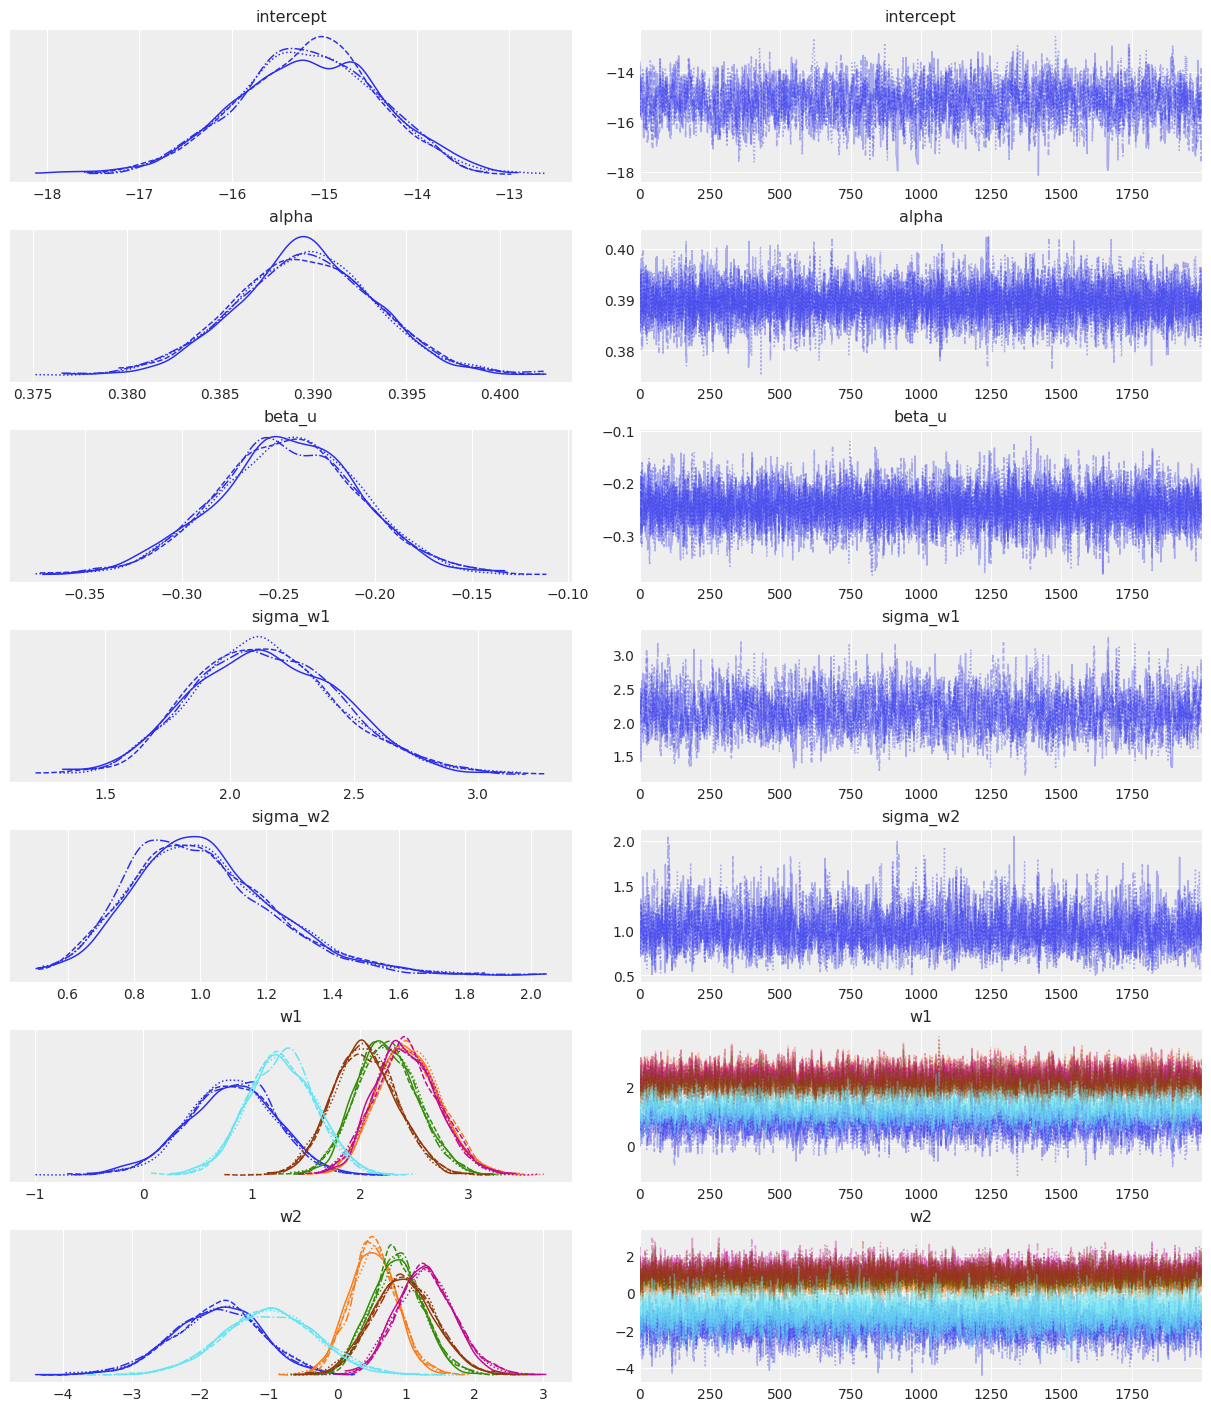

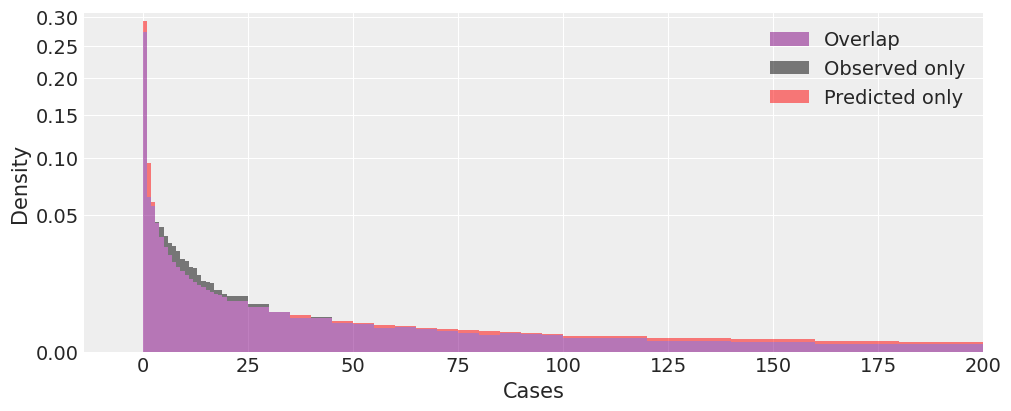

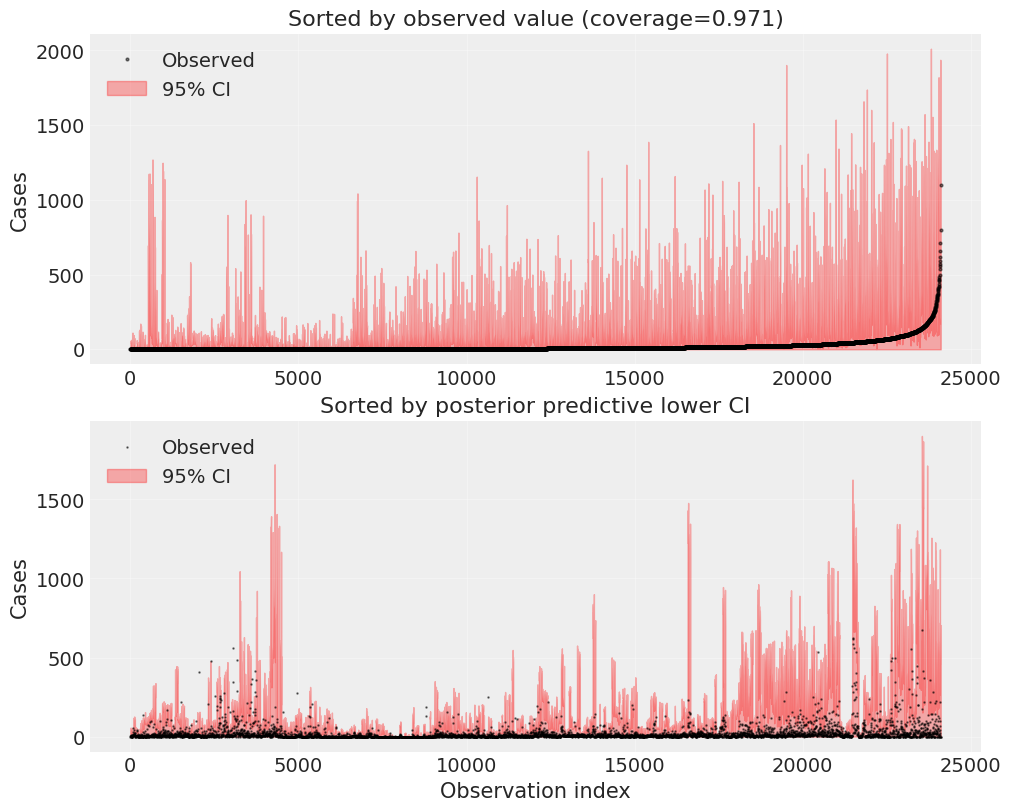

In [46]:
var_names = ['intercept', 'alpha', 'beta_u', 'sigma_w1', 'sigma_w2', 'w1', 'w2']
display(az.summary(idata, var_names=var_names))
az.plot_trace(idata, var_names=var_names)
hist_plot(idata, figsize=(10,4))
CI_plot_both(idata, figsize=(10,8))

/Users/lucaratzinger/.pyenv/versions/p-phylo-venv/lib/python3.14/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 8000 posterior samples and 24107 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -83147.98   344.58
p_loo       35.19        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     24106  100.0%
   (0.70, 1]   (bad)          1    0.0%
   (1, Inf)   (very bad)     0    0.0%

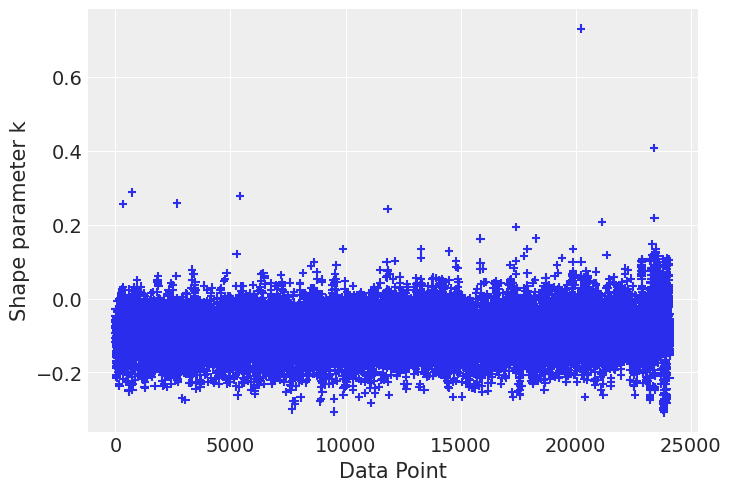

In [47]:
loo = az.loo(idata)
az.plot_khat(loo)
loo

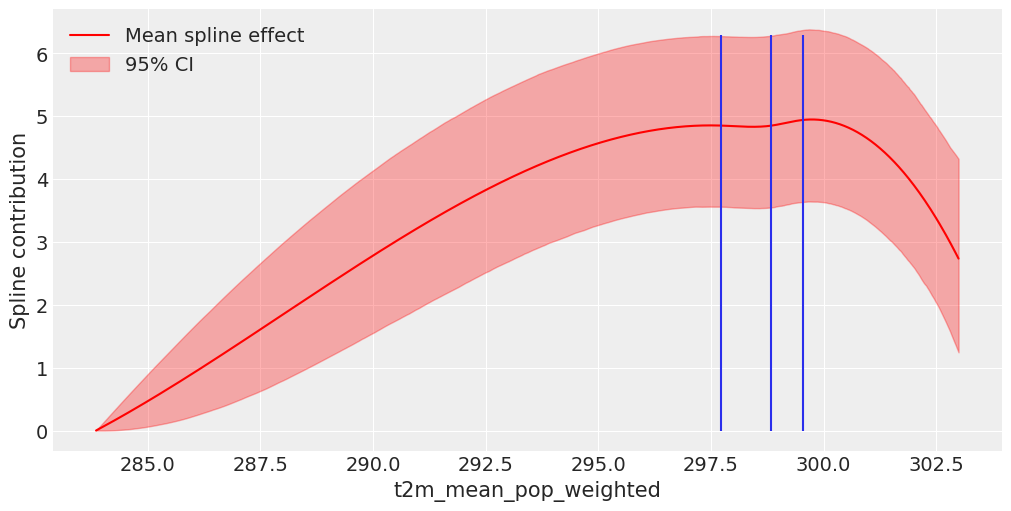

In [57]:
# Extract posterior samples
w_samples = idata.posterior['w1'].stack(draws=("chain", "draw")).values  # (n_basis, n_draws)
sigma_w_samples = idata.posterior['sigma_w1'].stack(draws=("chain", "draw")).values  # (n_draws,)

# Compute spline contributions for each draw
f_s1_samples = (np.asarray(B1, order="F") @ w_samples) * sigma_w_samples  # broadcasting: (n_obs, n_draws)

# Compute mean and 95% credible intervals
f_s1_mean = f_s1_samples.mean(axis=1)
f_s1_lower = np.percentile(f_s1_samples, 2.5, axis=1)
f_s1_upper = np.percentile(f_s1_samples, 97.5, axis=1)

# Plot
index = np.argsort(d1)
plt.figure(figsize=(10,5))
plt.plot(np.array(d1)[index], f_s1_mean[index], color='red', label='Mean spline effect')
plt.fill_between(np.array(d1)[index], f_s1_lower[index], f_s1_upper[index], color='red', alpha=0.3, label='95% CI')

plt.vlines(knot_list1, ymin=0, ymax=6.3)

plt.xlabel('t2m_mean_pop_weighted')
plt.ylabel('Spline contribution')
plt.legend()
plt.show()


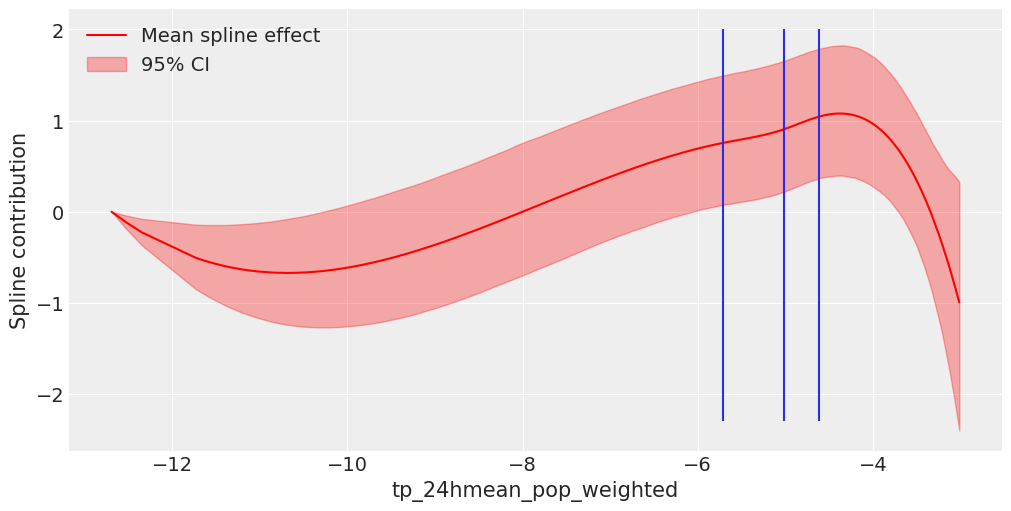

In [53]:
# Extract posterior samples
w_samples = idata.posterior['w2'].stack(draws=("chain", "draw")).values  # (n_basis, n_draws)
sigma_w_samples = idata.posterior['sigma_w2'].stack(draws=("chain", "draw")).values  # (n_draws,)

# Compute spline contributions for each draw
f_s1_samples = (np.asarray(B2, order="F") @ w_samples) * sigma_w_samples  # broadcasting: (n_obs, n_draws)

# Compute mean and 95% credible intervals
f_s1_mean = f_s1_samples.mean(axis=1)
f_s1_lower = np.percentile(f_s1_samples, 2.5, axis=1)
f_s1_upper = np.percentile(f_s1_samples, 97.5, axis=1)

# Plot
index = np.argsort(d2)
plt.figure(figsize=(10,5))
plt.plot(np.array(d2)[index], f_s1_mean[index], color='red', label='Mean spline effect')
plt.fill_between(np.array(d2)[index], f_s1_lower[index], f_s1_upper[index], color='red', alpha=0.3, label='95% CI')

plt.vlines(knot_list2, ymin=-2.3, ymax=2)

plt.xlabel('tp_24hmean_pop_weighted')
plt.ylabel('Spline contribution')
plt.legend()
plt.show()
